In [ ]:
%cd ..

In [ ]:
from src.transformer import GPT 
from src.utils import CfgNode as CN
import json
import torch
from safetensors.torch import load_model
import re
import chess
from IPython.display import display
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
conf = 'config.json'

C = CN()

with open(conf) as f:
    config = json.load(f)

C.n_layer = config["n_layer"]
C.n_embd = config["n_embd"]
C.n_head = config["n_head"]
C.embd_pdrop = config["embd_pdrop"]
C.resid_pdrop = config["resid_pdrop"]
C.attn_pdrop = config["attn_pdrop"]
C.block_size = 768

chars = ['0', '5', '2', 'Q', 'e', 'a', 'R', 'd', '9', '8', '1', 'N', 'x', 'f', '6', '+', 'c', '=', 'h', 'O', 'B', '.', '7', '/', '4', '3', '*', 'b', '-', ' ', 'K', 'g', '#', ';', '[PAD]']

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

C.vocab_size = len(stoi)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class GPT_probing(GPT):
    def __init__(self, config):
        super().__init__(config)
        self.n_layer = config.n_layer
    
    def forward(self, idx):
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."
        # assert 0 <= layer_num < self.n_layer,  "Cannot extract this layer"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        tok_emb = self.transformer.wte(idx) # shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # shape (1, t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        all_probs = []
        for block in self.transformer.h:
            x = block(x)
            all_probs.append(x[:,-1,:])
        return torch.stack(all_probs)

In [ ]:
model = GPT_probing(C).eval().to(device)
load_model(model, "models/stockfish-16/model.safetensors")

number of parameters: 50.85M


(set(), [])

In [ ]:
untrained_model = GPT_probing(C).eval().to(device)

number of parameters: 50.85M


In [ ]:
def get_probs(model, history):
    encoded_text = torch.tensor(encode(";1-0#" + history), dtype=torch.int64).unsqueeze(0).to(device)
    output = model(encoded_text).squeeze()
    return output.detach().cpu().numpy()

In [11]:
dataset = load_dataset("adamkarvonen/chess_games", data_files="stockfish_dataset.zip", split="train").select(range(100000))

Repo card metadata block was not found. Setting CardData to empty.


In [127]:
def get_board_from_PGN(pgn):
    board = chess.Board()
    for move in pgn.split():
        if '.' in move:
            move = move.split('.')[1]
        board.push_san(move)
    return board

def get_nxt_move_cases(board):
    cases = set()
    for move in board.legal_moves:
        move = board.san(move).replace('+', '').replace('#', '')
        if move == "O-O":
            cases.add("b1")
            cases.add("c1")
        elif move == "O-O-O":
            cases.add("f1")
            cases.add("e1")
        else:
            if '=' in move:
                move = move.split('=')[0]
            cases.add(move[-2:])
    return cases

def cases_to_grid(cases):
    grid = torch.zeros((8, 8))
    for case in cases:
        x, y = (ord(case[0]) - ord('a')), 8 - int(case[1])
        grid[y, x] = 1
    return grid

def board_to_array(board):
    piece_map = {
        "P": 1, "N": 2, "B": 3, "R": 4, "Q": 5, "K": 6,
        "p": 7, "n": 8, "b": 9, "r": 10, "q": 11, "k": 12
    }
    board_array = np.zeros((8, 8), dtype=int)
    
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            row, col = divmod(square, 8)
            board_array[7 - row, col] = piece_map[piece.symbol()]
    
    return board_array


def array_to_board(board_array):
    piece_map = {
        1: chess.PAWN, 2: chess.KNIGHT, 3: chess.BISHOP, 4: chess.ROOK, 5: chess.QUEEN, 6: chess.KING,
        7: chess.PAWN, 8: chess.KNIGHT, 9: chess.BISHOP, 10: chess.ROOK, 11: chess.QUEEN, 12: chess.KING
    }
    
    board = chess.Board.empty()
    
    for row in range(8):
        for col in range(8):
            piece_code = board_array[7 - row, col]  # Invert the row for chess board representation
            if piece_code != 0:
                # Déterminer la couleur en fonction du code de la pièce
                is_black = piece_code >= 7
                piece_code = piece_code - 6 if is_black else piece_code
                
                piece_symbol = piece_map[piece_code]
                piece = chess.Piece(piece_symbol, chess.BLACK if is_black else chess.WHITE)
                
                square = chess.square(col, row)
                board.set_piece_at(square, piece)
    
    return board

def get_grid_from_PGN(pgn):
    board = get_board_from_PGN(pgn)
    # cases = get_nxt_move_cases(board)
    grid = board_to_array(board)
    # grid = cases_to_grid(cases)
    return grid

def get_games_from_dataset(dataset, until_move=20, nb_games=10000):
    games = []
    for game in dataset:
        game = game["transcript"]
        if re.search(rf"{until_move}\.", game):
           game = game.split('\n\n')[1]
           pgn = game.split(f"{until_move}.")[0]
           games.append(pgn.strip())
           if len(games) >= nb_games:
               break
    return games

In [13]:
games = get_games_from_dataset(dataset, until_move=10, nb_games=10000)

In [ ]:
all_grids = []
all_probs = []
with torch.no_grad():
    for game in tqdm(games):
        try:
            # probs = get_probs(untrained_model, game)
            probs = get_probs(model, game)
            grid = get_grid_from_PGN(game)
        except Exception as e:
            print(e)
            print(game)
            continue
        all_probs.append(probs)
        all_grids.append(grid)

  6%|▋         | 631/10000 [00:07<01:53, 82.72it/s]

invalid san: 'Nf31'
1.Nf31.Nf6 d4 2.g6 c4 3.Bg7 Nc3 4.d5 Qb3 5.dxc4 Qxc4 6.O-O g3 7.Be6 Qb5 8.Nc6 Bg2 9.Nd5 O-O


 95%|█████████▌| 9540/10000 [01:56<00:05, 81.78it/s]

invalid san: 'Nf31'
1.Nf31.d5 d4 2.Nf6 g3 3.c5 dxc5 4.e6 Be3 5.Nbd7 Bg2 6.Bxc5 Bxc5 7.Nxc5 c4 8.O-O O-O 9.b6 b4


100%|██████████| 10000/10000 [02:02<00:00, 81.82it/s]


In [15]:
all_grids = np.array(all_grids)
all_probs = np.array(all_probs)

In [16]:
torch.save(all_grids, "grids.pt")
torch.save(all_probs, "probs.pt")

In [135]:
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

class ProbingDataset(Dataset):
    def __init__(self, grids, probs):
        """
        :param grids: Tensor de shape (N, 8, 8) contenant les labels des pièces (0 à 12)
        :param probs: Tensor de shape (N, 512) contenant les features d'entrée
        """
        self.grids = torch.tensor(grids).long()  # S'assurer que les labels sont bien des entiers
        self.probs = torch.tensor(probs).float()

    def __len__(self):
        return len(self.grids)
    
    def __getitem__(self, idx):
        return self.probs[idx], self.grids[idx]
    
class ProbingModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Linear(512, 13 * 8 * 8)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 13, 8, 8)
        return x 

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()  
    best_accuracy = 0
    all_accuracies = []

    for epoch in tqdm(range(epochs)):
        model.train()
        tot_loss = 0
        for probs, grids in train_loader:
            optimizer.zero_grad()
            preds = model(probs) 
            
            loss = loss_fn(preds, grids)
            loss.backward()
            tot_loss += loss.item()
            optimizer.step()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for probs, grids in val_loader:
                preds = model(probs)
                preds = preds.argmax(dim=1)
                
                correct += (preds == grids).sum().item()
                total += grids.numel()

        accuracy = correct / total
        all_accuracies.append(accuracy)
        # if accuracy > best_accuracy:
        #     best_accuracy = accuracy

    return all_accuracies

In [174]:
probs = torch.load('probs.pt')
grids = torch.load('grids.pt')

accuracies = []
for layer_num in range(probs.shape[1]):
    dataset = ProbingDataset(grids, probs[:,layer_num,:])
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
    model = ProbingModel()
    accuracies.append(train_model(model, train_loader, val_loader, epochs=50, lr=1e-3))

/tmp/ipykernel_1446887/1449405609.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  probs = torch.load('probs.pt')
/tmp/ipykernel_1446887/1449405609.py:2: FutureWarning: Y

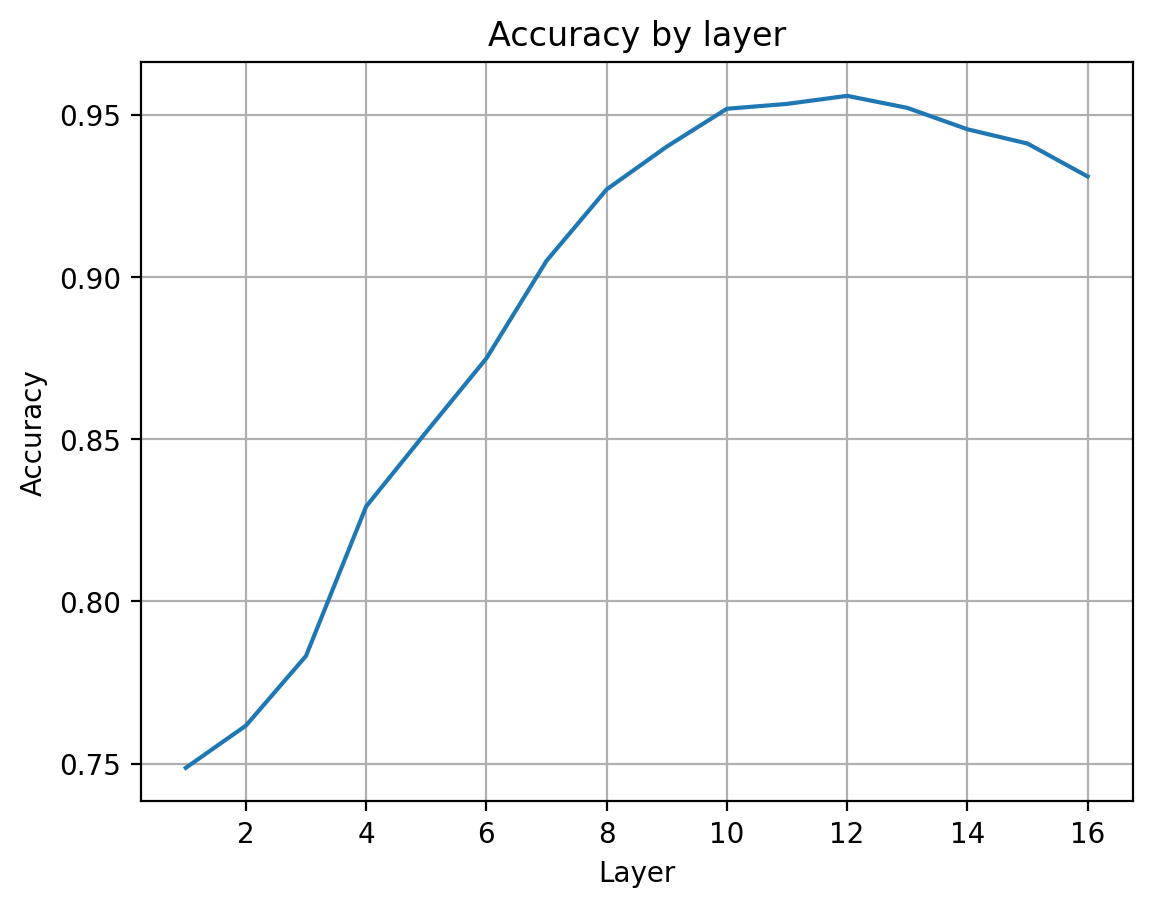

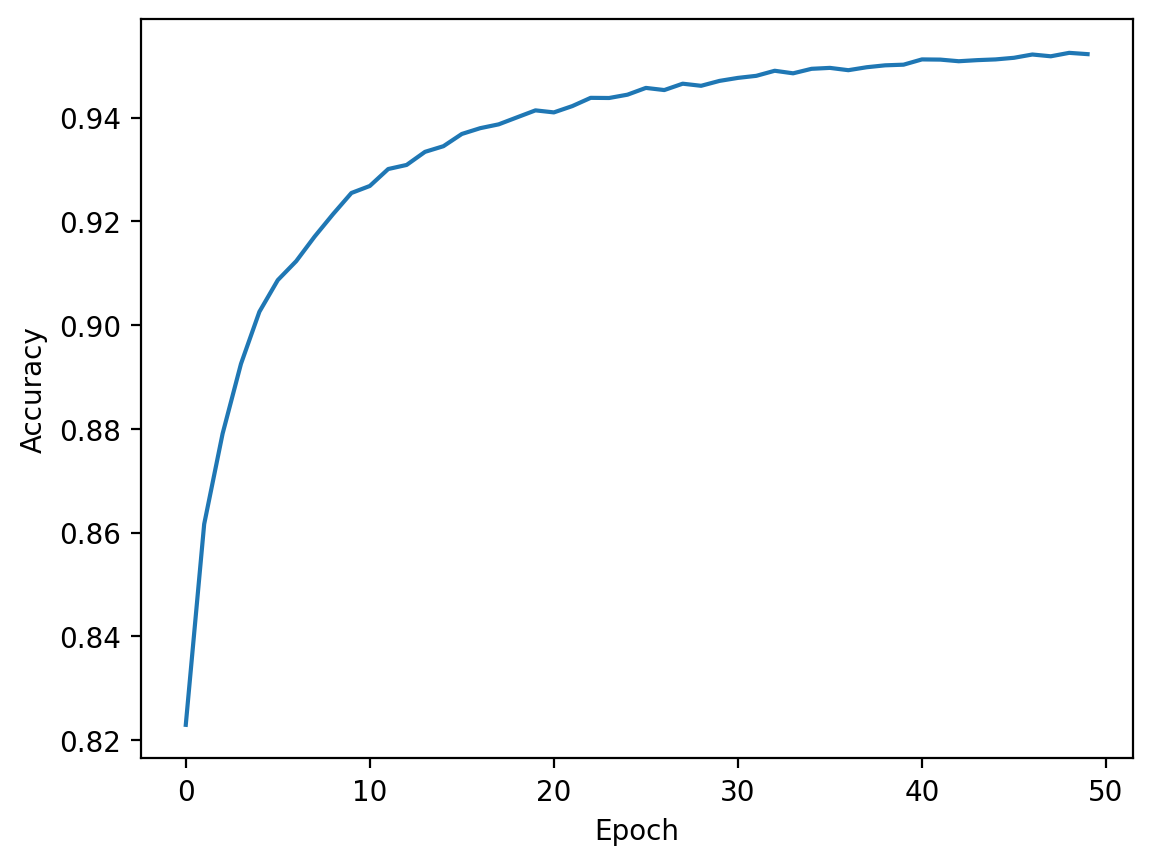

In [186]:
from matplotlib import pyplot as plt
import numpy as np

plt.plot(np.arange(1,len(accuracies)+1), np.array(accuracies)[:,-1])
plt.xlabel('Layer')
plt.ylabel('Accuracy')
# Title
plt.title('Accuracy by layer')
plt.grid()
plt.show()

layer_num = 12
plt.plot(accuracies[layer_num])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [172]:
layer_num = 12
dataset = ProbingDataset(grids, probs[:,layer_num,:])
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
model = ProbingModel()
accuracy = train_model(model, train_loader, val_loader, epochs=10, lr=1e-3)

100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Accuracy: 0.890625


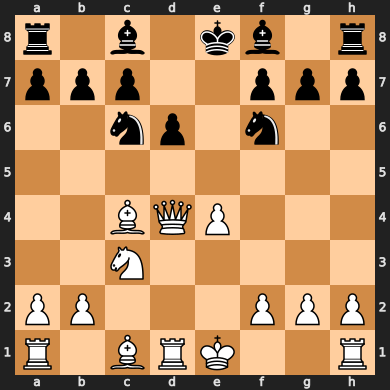

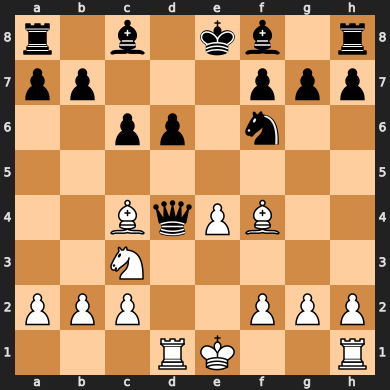

In [166]:
idx = np.random.randint(len(grids))
model.eval()
with torch.no_grad():
    outs = model(torch.tensor(probs)[idx:idx+1,layer_num,:])

print("Accuracy:", (outs.squeeze(0).argmax(0) == grids[idx]).float().mean().item())

reconstructed_board = array_to_board(outs.squeeze(0).argmax(0).numpy())
display(reconstructed_board)

original_board = array_to_board(grids[idx])
display(original_board)